# Deep Learning Notebook - LeNet
This example trains a LeNet-5 model using the Fashion MNist dataset, which is an alternative to the tradition MNist set of handwritten digits 0-9 that uses pictures of clothing items. The Fashion MNist set is included with Keras/Tensorflow


## Install dependencies

In [1]:
!pip install -r requirements.txt

## Import packages

In [2]:
import glob

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *

import numpy as np
from sklearn.model_selection import train_test_split
from skimage import filters, transform
import skimage.io as io
import matplotlib.pyplot as plt

## Preprocess images

### Load Fashion MNist and define classes

In [3]:
# Load fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
# Define class names for label values
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = len(class_names)

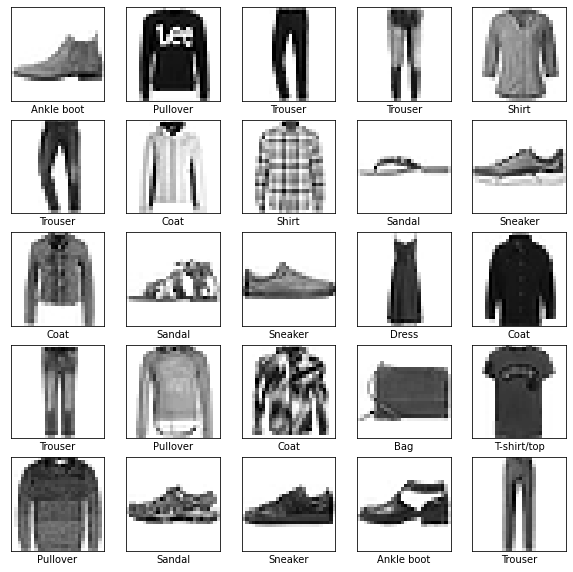

In [5]:
# Display example images with labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i]])
plt.show()

### Reshape images, normalize pixel values between 0-1, and convert to one-hot classes

In [6]:
# Preprocess images
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train/255.0
x_test = x_test/255.0

# Change classes to one-hot
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

## Create and train model

### Define model

In [7]:
def lenet(
    metrics,
    input_height=512, 
    input_width=512, 
    input_channels=1,  
    num_classes=2, 
    dropout=None, 
    activation='relu', 
    weights_path=None,
    loss='categorical_crossentropy',
    optimizer=SGD(lr=0.001, momentum=0.99)
):
    # Initialize model
    model = Sequential()

    input_shape = (input_height, input_width, input_channels)

    # Model layers
    model.add(Conv2D(16, 5, padding='same', input_shape=input_shape, activation=activation))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Conv2D(32, 5, padding='same', input_shape=input_shape, activation=activation))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation=activation))
    if dropout:
        model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    # If network was pretrained and saved with weights only
    if weights_path:
        model.load_weights(weights_path)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

### Create a Mirrored Strategy
Running a model with a Tensorflow MirroredStrategy allows the model to be trained across multiple GPUs. It is still compatible with single GPU or CPU training, so this code can be run on any cluster. The amount of memory (RAM or GPU) available will affect the available batch size.   

In [8]:
# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Build or load model

In [9]:
# Path to the model
model_path = None

# Open a strategy scope.
with strategy.scope():
    # Define metrics
    metrics = ['acc']
    
    # Instantiate model
    if model_path:
        print('Loading model...')
        model = tf.keras.models.load_model(model_path)
        print('Done')
    else:
        print('Building LeNet...')
        model = lenet(metrics=metrics, input_height=28, input_width=28, num_classes=10, dropout=0.5)
        print('Done')

Building LeNet...
Done


### Train model
The model training setup validates the training weights in real time using the testing dataset

In [10]:
batch_size = 32
epoch_steps = len(x_train)/batch_size
epochs = 25

if model_path is None:
    model_path = 'lenet.h5'

# Train the model
print('Training model')
model_checkpoint = ModelCheckpoint(model_path, monitor='acc', verbose=1, save_best_only=True)
H = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=batch_size,
          steps_per_epoch=epoch_steps, epochs=epochs, callbacks=model_checkpoint)

Training model
Epoch 1/25
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:

### Predict classes for the test set

In [12]:
predict_results = model.predict(x_test, batch_size=32)

## Visualize model results

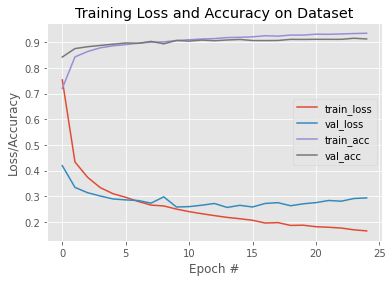

In [16]:
# plot the training loss and accuracy
N = 25
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="right")

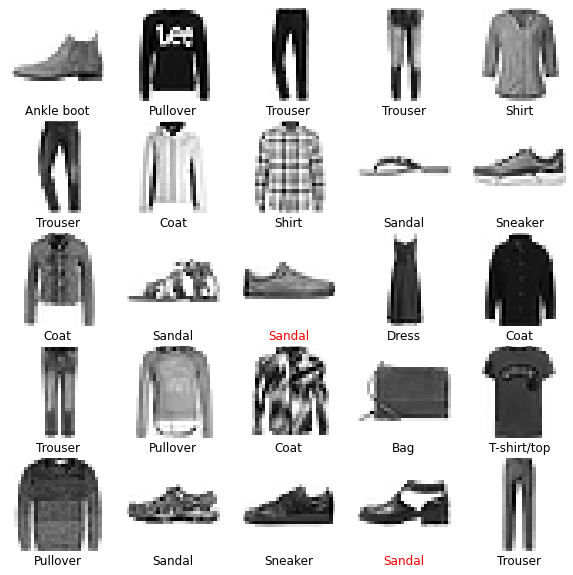

In [14]:
# Display example images with labels
# Red labels are incorrect
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    pred_class = np.argmax(predict_results[i])
    real_class = np.argmax(y_test[i])
    if pred_class == real_class: 
        plt.xlabel(class_names[pred_class], color='black')
    else:
        plt.xlabel(class_names[pred_class], color='red')
plt.show()

In [15]:
from numba import cuda
cuda.select_device(0)
cuda.close()